# Take-Home Challenge: Relax Challenge
## Notebook by Debisree Ray

The data is available as two attached CSV files:
* **takehome_user_engagement.csv**
* **takehome_users.csv**

The data has the following two tables:

1) A **user table ("takehome_users")** with data on 12,000 users who signed up for the product in the last two years. This table includes:

* **name:** the user's name
* **object_id:** the user's id
* **email:** email address
* **creation_source:** how their account was created. This takes on one of 5 values:
  * **PERSONAL_PROJECTS:** invited to join another user's personal workspace
  * **GUEST_INVITE:** invited to an organization as a guest (limited permissions)
  * **ORG_INVITE:** invited to an organization (as a full member)
  * **SIGNUP:** signed up via the website
  * **SIGNUP_GOOGLE_AUTH:** signed up using Google Authentication (using a Google email account for their login-id)
*  **creation_time:** when they created their account
* **last_session_creation_time:** unix timestamp of last login
* **opted_in_to_mailing_list:** whether they have opted into receiving marketing emails
* **enabled_for_marketing_drip:** whether they are on the regular marketing email drip
* **org_id:** the organization (group of users) they belong to
* **invited_by_user_id:** which user invited them to join (if applicable).


2) A **usage summary table ("takehome_user_engagement")** that has a row for each day that a user logged into the product.


Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.


We suggest spending 1-2 hours on this, but you're welcome to spend more or less. Please send us a brief writeup of your findings (the more concise, the better. no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigation you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.


In [2]:
import os
import math 
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

We have two datasets that will serve two different purposes: The first dataset, takehome_user_engagement.csv, will be used to determine whether any particular user is an adopted user or not (a user who has logged into the product on three separate days in at least one seven day period). The second dataset can then be used with the determined adopted user labels to create a classification model.


### 1. Data-set no. 1- 'takehome_user_engagement.csv':

In [74]:
df1= pd.read_csv('takehome_user_engagement.csv')
df1.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [75]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [77]:
df1.columns

Index(['time_stamp', 'user_id', 'visited'], dtype='object')

In [78]:
df1.shape

(207917, 3)

In [79]:
# Let's transform time_stamp to a datetime object
df1['time_stamp'] = pd.to_datetime(df1['time_stamp'])


# How many values does 'visited' take?
sorted(list(df1['visited'].unique()))

[1]

In [80]:
#Drop 'visited' column, the value is always 1:

df1.drop('visited', axis=1, inplace=True)
df1.head()

,time_stamp,user_id
0,2014-04-22 03:53:30,1
1,2013-11-15 03:45:04,2
2,2013-11-29 03:45:04,2
3,2013-12-09 03:45:04,2
4,2013-12-25 03:45:04,2


### Label users as 'Adopted':

In [81]:
# Create a dictionary that labels each user as adopted or not:
from datetime import timedelta

seven_days = timedelta(7)
adopted_dict = {}

for user_id in sorted(list(df1['user_id'].unique())):
    
    adopted_user = False
    temp = df1[df1['user_id'] == user_id]
    temp = temp.sort_values('time_stamp')
    
    for row in temp.itertuples():
        if adopted_user == True:
            continue
        
        this_time = temp.at[(row[0], 'time_stamp')]
        if len(temp[(temp['time_stamp'] >= this_time) & (temp['time_stamp'] <= (this_time + seven_days))]) >= 3:
            adopted_user = True
    
    adopted_dict[user_id] = adopted_user

### 2. Data-set no. 2- 'takehome_users.csv':

In [3]:
df = pd.read_csv('takehome_users.csv', encoding="latin1")
df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [105]:
# convert them to proper datetime format
df['last_session_creation_time'] = pd.to_datetime(df['last_session_creation_time'])
df['creation_time'] = pd.to_datetime(df['creation_time'])

In [5]:
#Drop the name,email

df.drop('name', axis=1, inplace=True)
df.drop('email', axis=1, inplace=True)

df.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803.0
1,2,2013-11-15 03:45:04,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0
2,3,2013-03-19 23:14:52,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525.0
3,4,2013-05-21 08:09:28,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151.0
4,5,2013-01-17 10:14:20,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240.0


In [6]:
df.columns

Index(['object_id', 'creation_time', 'creation_source',
       'last_session_creation_time', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id'],
      dtype='object')

In [7]:
df.shape

(12000, 8)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(4), object(1)
memory usage: 750.1+ KB


### 2.2 Exploratory Data Analysis:
### 2.2.1 Object ID:

In [15]:
df['object_id'].unique()

array([    1,     2,     3, ..., 11998, 11999, 12000])

### 2.2.2 Creation Time:

In [9]:
df['creation_time'].value_counts()

2014-02-11 17:57:53    2
2012-09-14 21:35:03    2
2012-09-01 07:22:09    2
2013-05-25 04:35:52    2
2013-09-13 08:15:45    1
                      ..
2014-03-16 13:52:40    1
2013-10-01 17:38:38    1
2013-06-08 20:18:35    1
2013-04-11 00:02:39    1
2013-06-25 00:29:04    1
Name: creation_time, Length: 11996, dtype: int64

### 2.2.3 Creation Source:

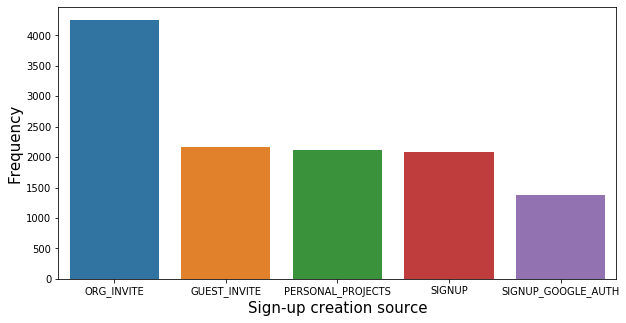

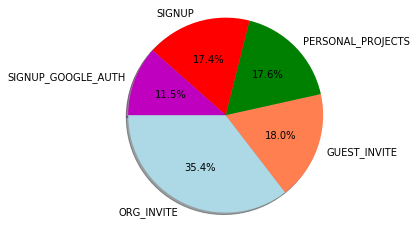

In [13]:
source=df['creation_source'].value_counts()

#Visually:
plt.figure(figsize=(10,5))
_=sns.barplot(source.index,source.values)
plt.xlabel('Sign-up creation source',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.savefig('1.png')
plt.show()


#Pieplot:

#Pieplot:
labels = source.index
sizes = source.values
colors = ('lightblue','coral','g','r','m')
explode = (0.00, 0,0,0,0)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.savefig("1a.png")
plt.show()

* This feature describes how the users account was created.
* 35.4% of times the account has been created by the invitation to an organization (as a full member)

### 2.2.4 Last_session_creation_time:

In [17]:
df['last_session_creation_time'].unique()

array(['1970-01-01T00:00:01.398138810', '1970-01-01T00:00:01.396237504',
       '1970-01-01T00:00:01.363734892', ...,
       '1970-01-01T00:00:01.398602716', '1970-01-01T00:00:01.338638159',
       '1970-01-01T00:00:01.390726632'], dtype='datetime64[ns]')

### 2.2.5 Opted in to mailing list:

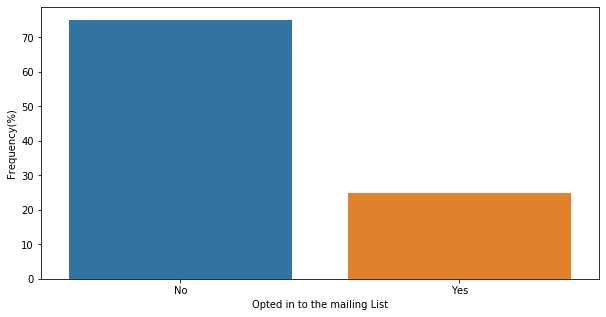

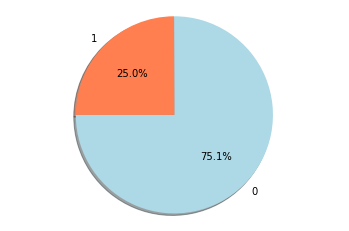

In [26]:
ls=df['opted_in_to_mailing_list'].value_counts(normalize=True)

#Visually:
plt.figure(figsize=(10,5))
_=sns.barplot(ls.index,ls.values*100)
plt.xticks([0,1], ['No','Yes'])
plt.xlabel('Opted in to the mailing List')
plt.ylabel('Frequency(%)')
plt.savefig('2.png')
plt.show()

#Pieplot:
labels = ls.index
sizes = ls.values
colors = ('lightblue','coral')
explode = (0.00, 0)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.savefig("2a.png")
plt.show()

* This feature describes whether the users have opted into receiving marketing emails or not.
* 75.1% of users have not opted for the mailing list.
* 25% of the users have opted for mailing list

### 2.2.6 Enabled_for_marketing_drip:

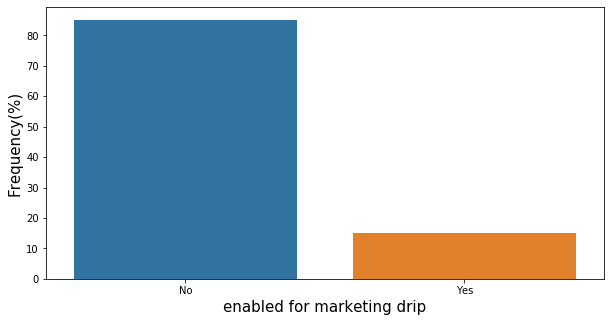

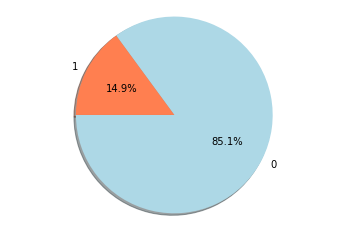

In [29]:
mark=df['enabled_for_marketing_drip'].value_counts(normalize=True)

#Visually:
#Visually:
plt.figure(figsize=(10,5))
_=sns.barplot(mark.index,mark.values*100)
plt.xticks([0,1], ['No','Yes'])
plt.xlabel('enabled for marketing drip',fontsize=15)
plt.ylabel('Frequency(%)',fontsize=15
          )
plt.savefig('3.png')
plt.show()

#Pieplot:
labels = mark.index
sizes = mark.values
colors = ('lightblue','coral')
explode = (0.00, 0)  # explode 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=180)
plt.axis('equal')
plt.savefig("3a.png")
plt.show()

### 2.2.7 Org ID:

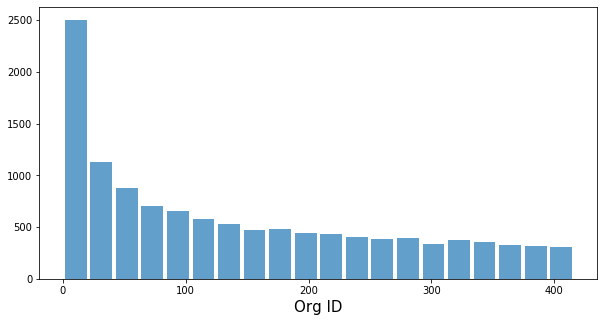

In [114]:
org=df['org_id'].value_counts()


#Visualization:
plt.figure(figsize=(10,5))
_= plt.hist(df['org_id'],bins=20,alpha=0.7, rwidth=0.85)
plt.xlabel('Org ID',fontsize=15)
plt.savefig('4.png')
plt.show()

### 2.3 Target variable: 'Adopted'

This dataset can then be used with the determined 'adopted' user labels to create a classification model.

In [65]:
# 'adopted' target variable:


df['adopted'] = False
df.head()

,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803.0,False
1,2,2013-11-15 03:45:04,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0,False
2,3,2013-03-19 23:14:52,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525.0,False
3,4,2013-05-21 08:09:28,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151.0,False
4,5,2013-01-17 10:14:20,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240.0,False


In [69]:
# Replace adopted target class with correct flags:

for row in (df[np.logical_not(df['last_session_creation_time'].isnull())]).itertuples():
    adopted_value = adopted_dict[df.get_value(row[0], 'object_id')]
    df.set_value(row[0], 'adopted', adopted_value)
    
print('{:.2f}% of all users who have signed up for the application are considered \'adopted users\'.'\
          .format(len(df[df['adopted'] == True])/len(df)*100))

13.80% of all users who have signed up for the application are considered 'adopted users'.


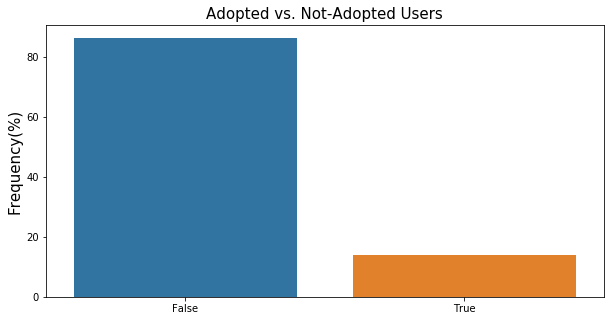

In [115]:
# Distribution of the target class:

adop= df['adopted'].value_counts(normalize=True)

#Visually:
plt.figure(figsize=(10,5))
_=sns.barplot(adop.index,adop.values*100)
plt.ylabel('Frequency(%)',fontsize=15)
plt.title('Adopted vs. Not-Adopted Users',fontsize=15)
plt.savefig('5.png')
plt.show()

### 2.4 Modelling:


In [83]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [98]:
# One-hot-encode creation_source:

df_encoded = pd.get_dummies(df, columns = ['creation_source'])

df_encoded.head()

,object_id,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,2014-04-22 03:53:30,1970-01-01 00:00:01.398138810,1,0,11,10803.0,False,1,0,0,0,0
1,2,2013-11-15 03:45:04,1970-01-01 00:00:01.396237504,0,0,1,316.0,True,0,1,0,0,0
2,3,2013-03-19 23:14:52,1970-01-01 00:00:01.363734892,0,0,94,1525.0,False,0,1,0,0,0
3,4,2013-05-21 08:09:28,1970-01-01 00:00:01.369210168,0,0,1,5151.0,False,1,0,0,0,0
4,5,2013-01-17 10:14:20,1970-01-01 00:00:01.358849660,0,0,193,5240.0,False,1,0,0,0,0


In [107]:
df_encoded = df_encoded.set_index('object_id')


df_encoded.columns

Index(['creation_time', 'last_session_creation_time',
       'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'adopted', 'creation_source_GUEST_INVITE',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH'],
      dtype='object')

In [108]:
df_encoded.head()

,creation_time,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
object_id,,,,,,,,,,,,
1,2014-04-22 03:53:30,1970-01-01 00:00:01.398138810,1,0,11,10803.0,False,1,0,0,0,0
2,2013-11-15 03:45:04,1970-01-01 00:00:01.396237504,0,0,1,316.0,True,0,1,0,0,0
3,2013-03-19 23:14:52,1970-01-01 00:00:01.363734892,0,0,94,1525.0,False,0,1,0,0,0
4,2013-05-21 08:09:28,1970-01-01 00:00:01.369210168,0,0,1,5151.0,False,1,0,0,0,0
5,2013-01-17 10:14:20,1970-01-01 00:00:01.358849660,0,0,193,5240.0,False,1,0,0,0,0


In [109]:
features_cols = ['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id',
       'invited_by_user_id', 'creation_source_GUEST_INVITE',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH']

features = df_encoded[features_cols]
#cat_df = X_df['package_id','from_area_id','to_area_id']
#features = cont_df.join(pd.get_dummies(cat_df))
y = df_encoded['adopted']

#features
X= features

In [110]:
#Missing values:

features.isnull().sum()

opted_in_to_mailing_list                 0
enabled_for_marketing_drip               0
org_id                                   0
invited_by_user_id                    5583
creation_source_GUEST_INVITE             0
creation_source_ORG_INVITE               0
creation_source_PERSONAL_PROJECTS        0
creation_source_SIGNUP                   0
creation_source_SIGNUP_GOOGLE_AUTH       0
dtype: int64

In [111]:
#Replace NaN/null values:


#features.last_session_creation_time.fillna(0, inplace=True)
features.invited_by_user_id.fillna(0, inplace=True)

In [118]:
# Split into test-train:

#train, test = train_test_split(df_encoded, test_size=.30, random_state=42, stratify=df_encoded['adopted'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


#Apply RF to the training data:

rf = RandomForestClassifier(bootstrap=True, class_weight= 'balanced', n_estimators=100,criterion='entropy')
rf.fit(X_train, y_train)

#Predict using the model:

y_predict_rf = rf.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_rf)
print(cnf_matrix)
Accuracy_rf=rf.score(X_test,y_test)
print(Accuracy_rf)

[[2714  386]
 [ 431   69]]
0.7730555555555556


                             Features  Importance scores
0            opted_in_to_mailing_list           0.003400
1          enabled_for_marketing_drip           0.003592
2                              org_id           0.004299
3                  invited_by_user_id           0.004426
4        creation_source_GUEST_INVITE           0.010789
5          creation_source_ORG_INVITE           0.011534
6   creation_source_PERSONAL_PROJECTS           0.013627
7              creation_source_SIGNUP           0.308439
8  creation_source_SIGNUP_GOOGLE_AUTH           0.639896


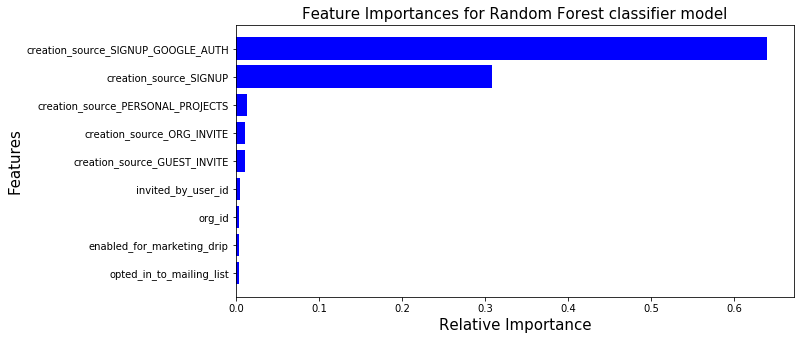

In [121]:
#Feature importance:

features = X
importances = list(rf.feature_importances_)
imp=np.sort(importances)

tab=pd.DataFrame(list(zip(X,imp)),columns =['Features', 'Importance scores']) 
print(tab)

#Visual comparison:
plt.figure(figsize=(10,5))
index = [0,1,2,3,4,5,6,7,8]
_=plt.barh(index,imp, align='center',color='b')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.yticks(index, features)
plt.title('Feature Importances for Random Forest classifier model',fontsize=15)
plt.savefig('6.png')
plt.show()